# Set up

Dataset [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification)

Pretrain Model [Vit](https://www.kaggle.com/datasets/abhinand05/vit-base-models-pretrained-pytorch)

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version 1.7
!pip install timm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     81      0 --:--:-- --:--:-- --:--:--    81
  File "/kaggle/working/pytorch-xla-env-setup.py", line 1
    404: Not Found
    ^^^
SyntaxError: illegal target for annotation


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

# need tpu
#import torch_xla
#import torch_xla.core.xla_model as xm
#import torch_xla.distributed.xla_multiprocessing as xmp
#import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

# Global Variables

In [3]:
# general global variables
DATA_PATH = "../input/cassava-leaf-disease-classification"
TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images/"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images/"
MODEL_PATH = (
    "../input/vit-base-models-pretrained-pytorch/jx_vit_base_p16_224-80ecf9dd.pth"
)

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 10

# Data

## Understand Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


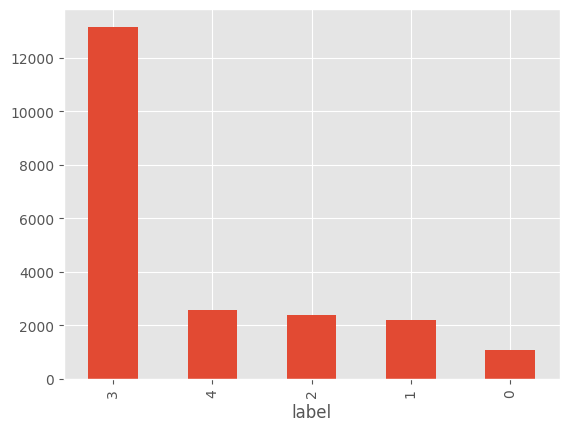

In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()
df.info()
df.label.value_counts().plot(kind="bar")
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

## DataClass

In [5]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [6]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

## Vit 16 Model

In [7]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32_clip_quickgelu_224',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_clip_224',
 

In [8]:
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

## train

In [9]:
train_dataset = CassavaDataset(train_df, transforms=transforms_train)
valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)


train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=4,
)

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        num_workers=4,
)
    
    

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

model = ViTBase16(n_classes=5, pretrained=True)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
lr = LR
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
#start_time = datetime.now()
#xm.master_print(f"Start Time: {start_time}")

#### training loop 
valid_loss_min = np.Inf  # track change in validation loss

# keeping track of losses as it happen
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

model.train()
for epoch in range(N_EPOCHS):
    gc.collect()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    batch_iterator = tqdm(train_loader, desc=f"Processing Epoch {epoch:02d}")
    for img, label in batch_iterator:
        optimizer.zero_grad()
        x = img.to(device)
        y = label.to(device)
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()
        
        accuracy = (out.argmax(dim=1) == y).float().mean()
        epoch_loss =epoch_loss + loss.item()
        epoch_accuracy =epoch_accuracy + accuracy
        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        
    epoch_loss = epoch_loss/ len(batch_iterator)
    epoch_accuracy = epoch_accuracy / len(batch_iterator)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_accuracy)
    
    #Validation
    valid_loss=0
    valid_accuracy=0
    model.eval()
    for img, label in valid_loader:
        x = img.to(device)
        y = label.to(device)
        with torch.no_grad():
            
            output = model(x)
            # calculate the batch loss
            loss = criterion(output, y)
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == y).float().mean()
            # update average validation loss and accuracy
            valid_loss += loss
            valid_accuracy += accuracy
            
    valid_loss = valid_loss/len(valid_loader)
    valid_accuracy = valid_accuracy/len(valid_loader)
    
    valid_losses.append(valid_loss)
    valid_accs.append(valid_accuracy)
    print(f"Epoch : {epoch} Train loss : {epoch_loss:6.3f} Train acc :{epoch_accuracy:6.3f} Val loss : {valid_loss:6.3f} Val acc : {valid_accuracy:6.3f}")
    
    #Save Model
    torch.save(model.state_dict(), 'model.t7')

    
    


Processing Epoch 00:   0%|          | 0/1204 [00:00<?, ?it/s]

Epoch : 0 Train loss :  0.784 Train acc : 0.807 Val loss :  0.730 Val acc :  0.833


RuntimeError: Parent directory checkpoints/models does not exist.